<a href="https://colab.research.google.com/github/asepdeffyc/bigdata/blob/main/2301201018_ASEP_DEFFY_UAS_BigData_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bike Rent Data Analysis 
### for Prediction bike rental count using Linear Regression Method

---
**Asep Deffy Ciftady**

2301201018

---

# Setting up PySpark in Colab

In [244]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q https://www-us.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz

In [245]:
!tar xf spark-3.1.2-bin-hadoop2.7.tgz

In [246]:
!pip install -q findspark

In [247]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [248]:
import findspark
findspark.init()

In [249]:
findspark.find()

'/content/spark-3.1.2-bin-hadoop2.7'

In [250]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [251]:
spark

In [252]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2021-06-29 16:54:59--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.196.34.225, 35.170.10.11, 52.87.103.240, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.196.34.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.19M  6.45MB/s    in 2.0s    

2021-06-29 16:55:02 (6.45 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   


In [253]:
get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels

{"tunnels":[{"name":"command_line","uri":"/api/tunnels/command_line","public_url":"https://032372ba58ad.ngrok.io","proto":"https","config":{"addr":"http://localhost:4050","inspect":true},"metrics":{"conns":{"count":0,"gauge":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0},"http":{"count":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0}}},{"name":"command_line (http)","uri":"/api/tunnels/command_line%20%28http%29","public_url":"http://032372ba58ad.ngrok.io","proto":"http","config":{"addr":"http://localhost:4050","inspect":true},"metrics":{"conns":{"count":0,"gauge":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0},"http":{"count":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0}}}],"uri":"/api/tunnels"}


# Preparation

## Import Library

In [254]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

# display all the columns
pd.options.display.max_columns = 999

## Load Data

In [255]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [256]:
sqlContext = SQLContext(spark)
harian_df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('drive/MyDrive/harian.csv')
harian_df.show(5)

+-------+----------+------+---+----+-------+-------+----------+----------+--------+--------+--------+---------+------+----------+----+
|instant|    dteday|season| yr|mnth|holiday|weekday|workingday|weathersit|    temp|   atemp|     hum|windspeed|casual|registered| cnt|
+-------+----------+------+---+----+-------+-------+----------+----------+--------+--------+--------+---------+------+----------+----+
|      1|2011-01-01|     1|  0|   1|      0|      6|         0|         2|0.344167|0.363625|0.805833| 0.160446|   331|       654| 985|
|      2|2011-01-02|     1|  0|   1|      0|      0|         0|         2|0.363478|0.353739|0.696087| 0.248539|   131|       670| 801|
|      3|2011-01-03|     1|  0|   1|      0|      1|         1|         1|0.196364|0.189405|0.437273| 0.248309|   120|      1229|1349|
|      4|2011-01-04|     1|  0|   1|      0|      2|         1|         1|     0.2|0.212122|0.590435| 0.160296|   108|      1454|1562|
|      5|2011-01-05|     1|  0|   1|      0|      3|   

# Exploratory Data

## Data Description

In [257]:
harian_df.cache()
harian_df.printSchema()

root
 |-- instant: integer (nullable = true)
 |-- dteday: string (nullable = true)
 |-- season: integer (nullable = true)
 |-- yr: integer (nullable = true)
 |-- mnth: integer (nullable = true)
 |-- holiday: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- workingday: integer (nullable = true)
 |-- weathersit: integer (nullable = true)
 |-- temp: double (nullable = true)
 |-- atemp: double (nullable = true)
 |-- hum: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- casual: integer (nullable = true)
 |-- registered: integer (nullable = true)
 |-- cnt: integer (nullable = true)



In [258]:
harian_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
instant,731,366.0,211.16581162678773,1,731
dteday,731,None,None,2011-01-01,2012-12-31
season,731,2.496580027359781,1.1108070927726252,1,4
yr,731,0.5006839945280438,0.5003418803818265,0,1
mnth,731,6.519835841313269,3.451912787256252,1,12
holiday,731,0.028727770177838577,0.16715474262247393,0,1
weekday,731,2.997264021887825,2.004786917944481,0,6
workingday,731,0.6839945280437757,0.4652333866777039,0,1
weathersit,731,1.3953488372093024,0.5448943419593665,1,3


## Correlation

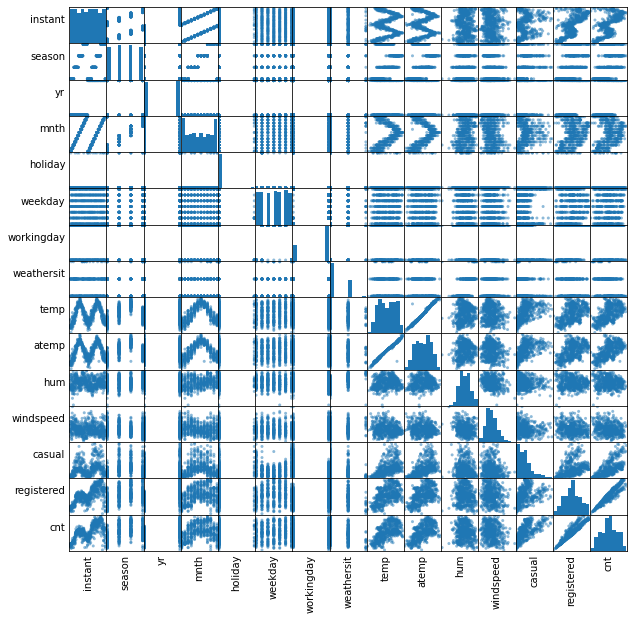

In [259]:
numeric_features = [t[0] for t in harian_df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = harian_df.select(numeric_features).sample(False, 0.8).toPandas()
axs = scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [260]:
import six
for i in harian_df.columns:
    if not( isinstance(harian_df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to cnt for ", i, house_df.stat.corr('cnt',i))

Correlation to cnt for  instant 0.6288302722083062
Correlation to cnt for  season 0.40610037079863526
Correlation to cnt for  yr 0.5667097078680867
Correlation to cnt for  mnth 0.2799771122192702
Correlation to cnt for  holiday -0.06834771589248398
Correlation to cnt for  weekday 0.06744341241063072
Correlation to cnt for  workingday 0.06115606306052115
Correlation to cnt for  weathersit -0.29739123883466345
Correlation to cnt for  temp 0.6274940090334915
Correlation to cnt for  atemp 0.6310656998491827
Correlation to cnt for  hum -0.1006585621371548
Correlation to cnt for  windspeed -0.2345449974216706
Correlation to cnt for  casual 0.6728044333386828
Correlation to cnt for  registered 0.9455169158090359
Correlation to cnt for  cnt 1.0


## Counting

[Text(0.5, 1.0, 'Count of bikes during different months')]

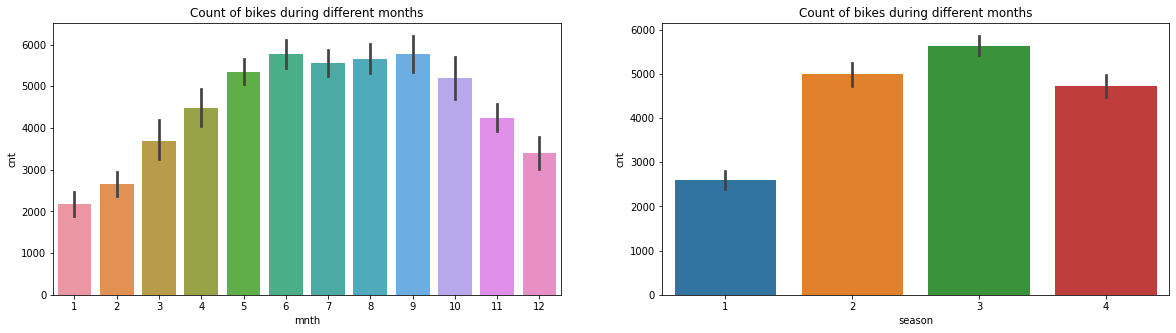

In [278]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20,5))
sns.barplot(data=df, x='mnth', y='cnt', ax=ax1)
ax1.set(title='Count of bikes during different months')
sns.barplot(data=df, x='season', y='cnt', ax=ax2)
ax2.set(title='Count of bikes during different months')

## Relation

[Text(0.5, 1.0, 'Relation between Windspeed and users')]

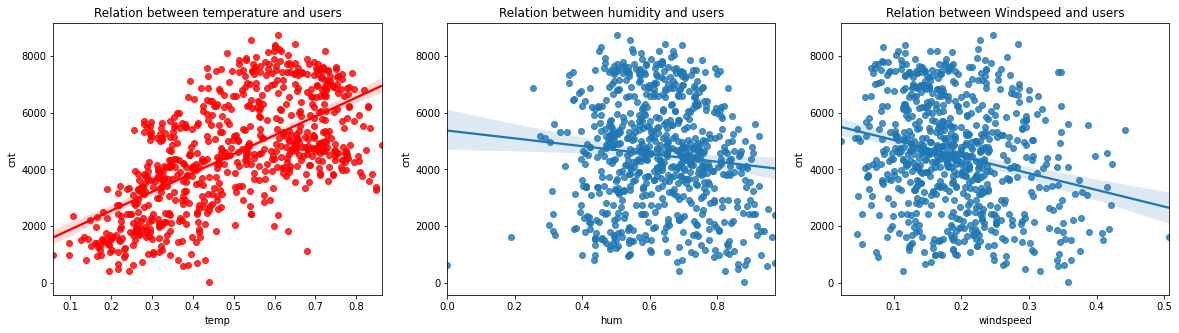

In [276]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(20,5))
sns.regplot(x=df['temp'], y=df['cnt'], ax=ax1 ,color='red')
ax1.set(title="Relation between temperature and users")
sns.regplot(x=df['hum'], y=df['cnt'], ax=ax2)
ax2.set(title="Relation between humidity and users")
sns.regplot(x=df['windspeed'], y=df['cnt'], ax=ax3)
ax3.set(title="Relation between Windspeed and users")

# Preprocessing

## Feature Selection

In [263]:
vectorAssembler = VectorAssembler(inputCols = ['season','yr','mnth','holiday','weekday','workingday','weathersit','temp','atemp','hum','windspeed'], outputCol = 'features')
feature_harian_df = vectorAssembler.transform(harian_df)
feature_harian_df = feature_harian_df.select(['features', 'cnt'])
feature_harian_df.show(5)

+--------------------+----+
|            features| cnt|
+--------------------+----+
|[1.0,0.0,1.0,0.0,...| 985|
|[1.0,0.0,1.0,0.0,...| 801|
|[1.0,0.0,1.0,0.0,...|1349|
|[1.0,0.0,1.0,0.0,...|1562|
|[1.0,0.0,1.0,0.0,...|1600|
+--------------------+----+
only showing top 5 rows



## Spliting Data

In [264]:
splits = feature_harian_df.randomSplit([0.8, 0.2])
train_df = splits[0]
test_df = splits[1]

# Linear Regression

In [265]:
lr = LinearRegression(featuresCol = 'features', labelCol='cnt', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [473.51399809090464,2086.3885581451414,-22.44365235688232,-407.2858568323832,54.945120705470224,154.9294690136457,-497.61922613762835,2496.191546756394,2979.5324845112987,-1208.838317986285,-2805.0208507452357]
Intercept: 1501.5573852771092


## Evaluation

In [266]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 835.816482
r2: 0.810388


In [267]:
train_df.describe().show()

+-------+------------------+
|summary|               cnt|
+-------+------------------+
|  count|               588|
|   mean|4553.9625850340135|
| stddev|1921.0897927435421|
|    min|               431|
|    max|              8555|
+-------+------------------+



## Model Test

In [268]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","cnt","features").show(5)

from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="cnt",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+----+--------------------+
|        prediction| cnt|            features|
+------------------+----+--------------------+
| 1280.929687397148|1321|[1.0,0.0,1.0,0.0,...|
|1687.7168397575833|1562|[1.0,0.0,1.0,0.0,...|
|1001.9720214330723| 683|[1.0,0.0,1.0,0.0,...|
| 62.21093273966085| 506|[1.0,0.0,1.0,0.0,...|
| 1278.181490677883|1406|[1.0,0.0,1.0,0.0,...|
+------------------+----+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.751255


In [269]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 992.033


## Prediction

In [309]:
test_df.take(1)

[Row(features=DenseVector([1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.1508, 0.1509, 0.4829, 0.2233]), cnt=1321)]

In [310]:
from pyspark.ml.linalg import Vectors
prediction_df = spark.createDataFrame([
    (Vectors.dense([3.0, 0.0, 8.0, 0.0, 0.0, 0.0, 2.0, 0.6767, 0.6244, 0.8175, 0.2226]), 3820),
    (Vectors.dense([1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.1508, 0.1509, 0.4829, 0.2233]), 1321)
], ["features", "cnt"])

prediction_df.take(2)

[Row(features=DenseVector([3.0, 0.0, 8.0, 0.0, 0.0, 0.0, 2.0, 0.6767, 0.6244, 0.8175, 0.2226]), cnt=3820),
 Row(features=DenseVector([1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.1508, 0.1509, 0.4829, 0.2233]), cnt=1321)]

In [299]:
test_df.dtypes

[('features', 'vector'), ('cnt', 'int')]

In [311]:
predictions = lr_model.transform(prediction_df)
predictions.select("prediction","cnt","features").show()

+------------------+----+--------------------+
|        prediction| cnt|            features|
+------------------+----+--------------------+
|3684.2816451087374|3820|[3.0,0.0,8.0,0.0,...|
|1280.8110520292503|1321|[1.0,0.0,1.0,0.0,...|
+------------------+----+--------------------+

